# Ejemplo de programación elementos finitos.
## Introducción.

El objetivo de esta práctica es ver una pequeña introducción a como preparar un programa de cálculo de elementos finitos.
Para ello partiremos de un ejemplo de un modelo de barras en dos dimensiones (celosías).
A partir del ejemplo se irán desarrollando paso a paso las distintas funciones necesarias para su solución.
La programación se realizará en python utilizando las siguientes librerías:

1. math
1. numpy
2. scipy
3. matplotlib

El código se implementará en un notebook de jupyter que permite la mezcla de texto, gráficos y código de forma sencilla mediante el uso de celdas de tipo *markdown* o tipo *code*.


In [1]:
import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
import math

## Ejemplo

Vamos a utilizar el siguiente ejemplo:

![esquema](17_d.png)

Como en el lenguaje python los arrays, listas, etc. se indexan empezando por cero, uilizaremos ese convenio en la descripción del modelo.
Los nodos se numerarán de forma correlativa empezando por cero, con los elementos se hará de forma similar y para establecer las fuerzas concentradas en nodos se usará el nodo, la dirección (0 el eje x y 1 el eje y) y el valor. Las condiciones de contorno se definirán de forma similar a las fuerzas pero sin el dato valor.
Si resumimos la información del modelo relevante para el cálculo observamos lo siguiente:

* Coordenadas de los nodos.

| Nodo  |   x  |  y|
| ---   | --- | ---|
| 0     |  0   |  0 |
| 1    |   2  |  0 |
| 2    |   1  | 0   |

*  Elementos (barras articuladas)

| Elemento  |  nodo 1  |  nodo  2  |   EA    |
| ---       | ---      | ---       | ---     |
|    0      |    0     |   1       |   1000  |
|    1      |    0     |   2        |  1000  |
|    2      |    1     |   2        |  1000  |

* fuerzas aplicadas

| Nodo  |  dirección  | valor |
| ---   | ---         | ---   |
| 2     |    0        | 1    |

* Condiciones de contorno

| Nodo  |  dirección  | 
| ---   | ---         | 
| 0     |    0        | 
| 0     |    1        | 
| 1     |    1        | 


Lo primero que se hará es definir formalmente el modelo en el lenguaje en cuestión. Para el caso que nos ocupa usaremos un array del tipo numpy para las coordenadas y listas para los elementos, las fuerzas y las condiciones de contorno.
Crearemos las variables correspondientes con los nombres que nos parezcan oportunos.

Para los nodos un array con sus coordenadas [[x0,y0],[x1,y1],...]
Para los elementos una lista con los mismos [el1,el2,....], donde cada elemento es [nodo 1, nodo 2, EA]
Para las fuerzas una lista con cada una de ellas [[nodo,dirección,F_val],...]
Y para las condiciones de contorno una lista similar[[nodo,dirección],...]
Escribiéndolo en python tendríamos lo siguiente

In [2]:
x = np.array([[0,0],[2,0],[1,2]])
elementos = [[0,1,1000],[0,2,1000],[1,2,1000]]
fuerzas = [[2,0,1]]
cc = [[0,0],[0,1],[1,1]]

## Matriz de rigidez del modelo

El objetivo del cálculo es llegar a una ecuación del tipo $\mathbf{K}\mathbf{d}=\mathbf{f}$ donde $\mathbf{K}$ es la matriz de rigidez global del modelo que se obtiene a partir de las matrices de rigidez de cada elemento ensambladas (sumadas en una cierta posición dependiente de los nodos) en la global.

El vector de fuerzas $\mathbf{f}$ también se obtiene de forma similar ensamblando las fuerzas dadas cada una de ellas en la posición correspondiente.

Como los grados de libertad considerados son dos por nodo (u según x,v según y) las dimensiones de las matrices serán siendo $n$ el número de nodos.

|   Matriz    |  dimensión |
|  ----       |   -------  |
| $\mathbf{K}$ | $2n\times2n$ |
| $\mathbf{d}$ | $2n$        |
| $\mathbf{f}$ | $2n$      |

Al haber indexado a partir de cero la relación entre nodo, dirección y grado de libertad es muy sencilla:
Al nodo $i$, dirección $j$ le corresonde el grado de libertad (índice en las matrices)  $2i+j$


## Matriz de rigidez elemental

Primeramente obtendremos la función matriz de rigidez de un elemento.
Una vez obtenida se aplicará esa función a todos los elementos y se ensamblarán.

La matriz de rigidez del elemento es:

$ \mathbf{K}_{el} = 
\frac{EA}{l}\begin{pmatrix}
c^2 & cs & -c^2 & -cs \\
cs  & s^2 & cs & s^2 \\
-c^2 & -cs & c^2 & cs \\
-cs &  -s^2 & cs & s^2
\end{pmatrix}
$
siendo $c$ el coseno del ángulo que forma la barra con la horizontal y $s$ el seno.

Como se puede observar, en este caso, está formada por un bloque de $2\times2$ que se repite cuatro veces, dos de ellas con el signo cambiado.

Si denominamos al bloque básico $\mathbf{K}_{11}$ tendríamos lo siguiente
$ \mathbf{K_{11}} = 
\frac{EA}{l}\begin{pmatrix}
c^2 & cs \\
cs & s^2 
\end{pmatrix}
$

y por tanto:
$ \mathbf{K_{el}} = 
\begin{pmatrix}
\mathbf{K}_{11} & -\mathbf{K}_{11} \\
-\mathbf{K}_{11}& \mathbf{K}_{11} 
\end{pmatrix}
$

Vamos a proceder paso a paso escribiendo funciones para obtener la matriz de rigidez elemental. Partimos de un elemento que está definido por: [nodo 1,nodo 2, EA].
Además necesitaremos las coordenadas de los nodos (en concreto las diferencias) para obtener la longitud y los senos y los cosenos.


La primera función que vamos incluir es la que accede a las coordenadas de los nodos
Argumentos:
1. elemento,coordenadas
   [nodo 1,nodo 2, EA] , coordenadas
Resultado:
1. elemento modificado
   [nodo 1, nodo 2, EA,x2-x1,y2-y1]


In [3]:
fk_0 = lambda el,coor: [el[0],el[1],el[2],coor[el[1]][0]-coor[el[0]][0],coor[el[1]][1]-coor[el[0]][1]]

In [4]:
fk_0(elementos[1],x)

[0, 2, 1000, 1, 2]

La siguiente función calcula la longitud del elemento
Argumentos:
1. elemento
   [nodo 1,nodo 2, EA,x2-x1,y2-y1] 
Resultado:
1. elemento modificado
   [nodo 1, nodo 2, EA,l,x2-x1,y2-y1]

In [5]:
fk_1 = lambda el: [el[0],el[1],el[2],math.hypot(el[3],el[4]),el[3],el[4]]

In [6]:
fk_0(elementos[0],x)
fk_1(fk_0(elementos[0],x))

[0, 1, 1000, 2.0, 2, 0]

La siguiente función obtiene el coseno y el seno y la rigidez axial $\frac{EA}{l}$  del elemento donde tanto el coseno como el seno se obtienen a partir de las diferencias de coordenadas y de la longitud

In [7]:
fk_2 = lambda el: [el[0],el[1],el[2]/el[3],el[4]/el[3],el[5]/el[3]]

In [8]:
fk_0(elementos[0],x)
fk_1(fk_0(elementos[0],x))
fk_2(fk_1(fk_0(elementos[0],x)))

[0, 1, 500.0, 1.0, 0.0]

Ahora se puede obtener el bloque elemental $\mathbf{K}_{11}$ de la matriz de rigidez elemental
$ \mathbf{K_{11}} = 
\frac{EA}{l}\begin{pmatrix}
c^2 & cs \\
cs & s^2 
\end{pmatrix}
$

In [9]:
fk_11 = lambda el: el[2]*np.array([[el[3]**2,el[3]*el[4]],[el[3]*el[4],el[4]**2]])

In [10]:
fk_11(fk_2(fk_1(fk_0(elementos[0],x))))

array([[500.,   0.],
       [  0.,   0.]])

Y a partir del bloque $\mathbf{K}_{11}$ podemos obtener la matriz de rigidez local del elemento
$ \mathbf{K_{el}} = 
\begin{pmatrix}
\mathbf{K}_{11} & -\mathbf{K}_{11} \\
-\mathbf{K}_{11}& \mathbf{K}_{11} 
\end{pmatrix}
$

In [11]:
fk_loc = lambda k11: np.vstack((np.hstack((k11,-k11)),np.hstack((-k11,k11))))

In [12]:
fk_loc(fk_11(fk_2(fk_1(fk_0(elementos[0],x)))))

array([[ 500.,    0., -500.,   -0.],
       [   0.,    0.,   -0.,   -0.],
       [-500.,   -0.,  500.,    0.],
       [  -0.,   -0.,    0.,    0.]])

Todas las funciones auxiliares para obtener la matriz de rigidez las podemos juntar en una sola.

In [13]:
fk_el = lambda elemento,coor: fk_loc(fk_11(fk_2(fk_1(fk_0(elemento,coor)))))

In [14]:
fk_el(elementos[2],x)

array([[  89.4427191, -178.8854382,  -89.4427191,  178.8854382],
       [-178.8854382,  357.7708764,  178.8854382, -357.7708764],
       [ -89.4427191,  178.8854382,   89.4427191, -178.8854382],
       [ 178.8854382, -357.7708764, -178.8854382,  357.7708764]])

## Matriz de rigidez de un conjunto de elementos y ensamblaje

Una vez que tengo una función para obtener la matriz de rigidez de un elemento, la forma de obtener las matrices de rigidez de todos los elementos es aplicar esa función a todos los elementos.

In [15]:
fk_els = lambda elementos,coor: map(lambda elemento: fk_el(elemento,coor),elementos)

In [16]:
list(fk_els(elementos,x))

[array([[ 500.,    0., -500.,   -0.],
        [   0.,    0.,   -0.,   -0.],
        [-500.,   -0.,  500.,    0.],
        [  -0.,   -0.,    0.,    0.]]),
 array([[  89.4427191,  178.8854382,  -89.4427191, -178.8854382],
        [ 178.8854382,  357.7708764, -178.8854382, -357.7708764],
        [ -89.4427191, -178.8854382,   89.4427191,  178.8854382],
        [-178.8854382, -357.7708764,  178.8854382,  357.7708764]]),
 array([[  89.4427191, -178.8854382,  -89.4427191,  178.8854382],
        [-178.8854382,  357.7708764,  178.8854382, -357.7708764],
        [ -89.4427191,  178.8854382,   89.4427191, -178.8854382],
        [ 178.8854382, -357.7708764, -178.8854382,  357.7708764]])]

Podría hacerse sin necesidad de definir la función auxiliar fk_els

In [17]:
list((lambda elementos,coor: map(lambda elemento: fk_el(elemento,coor),elementos))(elementos,x))

[array([[ 500.,    0., -500.,   -0.],
        [   0.,    0.,   -0.,   -0.],
        [-500.,   -0.,  500.,    0.],
        [  -0.,   -0.,    0.,    0.]]),
 array([[  89.4427191,  178.8854382,  -89.4427191, -178.8854382],
        [ 178.8854382,  357.7708764, -178.8854382, -357.7708764],
        [ -89.4427191, -178.8854382,   89.4427191,  178.8854382],
        [-178.8854382, -357.7708764,  178.8854382,  357.7708764]]),
 array([[  89.4427191, -178.8854382,  -89.4427191,  178.8854382],
        [-178.8854382,  357.7708764,  178.8854382, -357.7708764],
        [ -89.4427191,  178.8854382,   89.4427191, -178.8854382],
        [ 178.8854382, -357.7708764, -178.8854382,  357.7708764]])]

Con vistas al ensamblaje nos conviene tener todos los elementos de las matrices de rigidez en un array unidimensional. Para ello usaremos la función np.ravel y definimos una nieva función

In [18]:
f_kg1 = lambda elementos,coordenadas:np.ravel(list(fk_els(elementos,coordenadas)))

In [19]:
f_kg1(elementos,x)

array([ 500.       ,    0.       , -500.       ,   -0.       ,
          0.       ,    0.       ,   -0.       ,   -0.       ,
       -500.       ,   -0.       ,  500.       ,    0.       ,
         -0.       ,   -0.       ,    0.       ,    0.       ,
         89.4427191,  178.8854382,  -89.4427191, -178.8854382,
        178.8854382,  357.7708764, -178.8854382, -357.7708764,
        -89.4427191, -178.8854382,   89.4427191,  178.8854382,
       -178.8854382, -357.7708764,  178.8854382,  357.7708764,
         89.4427191, -178.8854382,  -89.4427191,  178.8854382,
       -178.8854382,  357.7708764,  178.8854382, -357.7708764,
        -89.4427191,  178.8854382,   89.4427191, -178.8854382,
        178.8854382, -357.7708764, -178.8854382,  357.7708764])

Para poder enamblar las matrices de rigidez es necesario saber a que índices de la matriz de rigidez global va cada elemento de una matriz de rigidez elemental.
Vamos a crear unas funciones que nos den esos índices en función de los nodos del elemento, una función para las filas de todos los elementos de la matriz y otra función para las columnas.


In [20]:
columnask = lambda y:  np.array(list(( map(lambda x: [x*2,x*2+1],y)))*4).flatten()
filask = lambda y:  np.array(list(( map(lambda x: [list([x*2])*4,list([x*2+1])*4],y)))).flatten()

In [21]:
print(filask((0,1)))
print(columnask((1,2)))

[0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3]
[2 3 4 5 2 3 4 5 2 3 4 5 2 3 4 5]


Si se aplican las funciones a un conjunto de elementos se definen las siguientes funciones

In [22]:
fco = lambda elementos: list(np.ravel(list(map(lambda u: columnask((u[0],u[1])),elementos))))
ffi = lambda elementos: list(np.ravel(list(map(lambda u: filask((u[0],u[1])),elementos))))

Como ejemplo se puede aplicar a todos nuestros elementos:

In [23]:
print(fco(elementos))

[0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 4, 5, 0, 1, 4, 5, 0, 1, 4, 5, 0, 1, 4, 5, 2, 3, 4, 5, 2, 3, 4, 5, 2, 3, 4, 5, 2, 3, 4, 5]


Una vez que se dispone de las matrices de rigidez de todos los elementos y las filas y columnas de cada elemento de cada matriz se pueden ensamblar en la matriz de rigidez global.
Utilizaremos el formato de matriz sparse del módulo de python scipy que a la vez que genera la matriz sparse va sumando los distintos elemntos.


In [24]:
f_kg = lambda elementos,puntos: sp.csr_matrix(sp.coo_matrix((f_kg1(elementos,puntos),(fco(elementos),ffi(elementos))),shape=(len(puntos)*2,len(puntos)*2)))


In [25]:
print(f_kg(elementos,x).todense())

[[ 589.4427191  178.8854382 -500.           0.         -89.4427191
  -178.8854382]
 [ 178.8854382  357.7708764    0.           0.        -178.8854382
  -357.7708764]
 [-500.           0.         589.4427191 -178.8854382  -89.4427191
   178.8854382]
 [   0.           0.        -178.8854382  357.7708764  178.8854382
  -357.7708764]
 [ -89.4427191 -178.8854382  -89.4427191  178.8854382  178.8854382
     0.       ]
 [-178.8854382 -357.7708764  178.8854382 -357.7708764    0.
   715.5417528]]


## Condiciones de contorno

La matriz obtenida es singular dado que no hemos incluido ninguna condición de contorno.

In [26]:
np.linalg.det(f_kg(elementos,x).todense())


0.0

Las condiciones de contorno podrían incluirse eliminando las filas y columnas de la matriz de rigidez correspondientes a los grados de libertad restringidos pero una forma más simple es imponiendo las restricciones por penalización. Se añaden en los elementos de  la diagonal de la matriz de rigidez correspondientes a los grados de libertad restringidos unos valores de rigidez muy elevados que imponend forma aproximada el cumplimiento de la restricción.
De este modo se mantienen las dimensiones de las matrices que en el otro caso habrían cambiado.

Si denominamos al valor elevado de rigidez $kpen$ y tenemos en el nodo $i$ restringido el grado de libertad $j$ basta con añadir el valor $kpen$ al elemento de la matriz de rigidez global $\left(2i+j,2i+j\right)$

Al generar la matriz de rigidez global se añaden estos elementos con sus índices correspondientes.

In [27]:
kpen = 1e20
f_cc1 = lambda cc: list(map(lambda u: kpen,cc))
f_cc2 = lambda cc: list(map(lambda u: u[0]*2+u[1],cc))
f_kgp = lambda elementos,puntos,cc: sp.csr_matrix(sp.coo_matrix((np.hstack((f_kg1(elementos,puntos),f_cc1(cc))),(fco(elementos)+f_cc2(cc),ffi(elementos)+f_cc2(cc))),shape=(len(puntos)*2,len(puntos)*2)))

In [28]:
np.linalg.det(f_kgp(elementos,x,cc).todense())


6.400000000000038e+67

## Fuerzas

El vector de fuerzas se obtiene de forma similar a la matriz de rigidez. Se crea una matriz sparse a partir de los valores de las fuerzas aplicadas y de los grados de libertad correspondientes.
Para ello usaremos dos funciones auxiliares.
1. f_b1 transforma la lista de fuerzas en una lista con los valores de las fuerzas y las filas del vector global f (además de un 0 para la columna)
2. f_b ensambla el vector de fuerzas en una matriz sparse


In [29]:
# fb da el vector de fuerzas en funcion de [[nodo,direccion,fuerza],...] y puntos
f_b1 = lambda fuerzas,puntos: (list(map(lambda u: u[2],fuerzas)),(list(map(lambda u: u[0]*2+u[1],fuerzas)),list(map(lambda u: 0,fuerzas))))
f_b = lambda fuerzas,puntos: sp.csr_matrix(sp.coo_matrix((f_b1(fuerzas,puntos)),shape=(len(puntos)*2,1)))

In [30]:
print(f_b(fuerzas,x))

  (4, 0)	1


Hemos obtenido una matriz sparse de $6\times1$ con un elemento no nulo de valor $1$ en el índice 4 que se corresponde con el nodo $2$ y dirección $x$

Una vez que tenemos la matriz de rigidez global y el vector de fuerzas global podemos resolver el sistema de ecuaciones 

In [31]:
d = spsolve(f_kgp(elementos,x,cc),f_b(fuerzas,x)).reshape(3,2)
print(d)

[[ 1.00000000e-20  1.00000000e-20]
 [ 1.00000000e-03 -1.00000000e-20]
 [ 6.09016994e-03 -2.50000000e-04]]


Podemos crear una función para resolver el problema

In [32]:
f_solve = lambda x,els,fuerzas,cc: spsolve(f_kgp(els,x,cc),f_b(fuerzas,x)).reshape(len(x),2)

In [33]:
u = f_solve(x,elementos,fuerzas,cc)

Utilizaremos las siguientes funciones para dibujar los nodos o los elementos

In [34]:
f_dibnodos= lambda puntos,color='go': plt.plot(puntos[:,0],puntos[:,1],color)
f_dibelems = lambda puntos,elementos,color='r':plt.plot(*(sum(list(map(lambda u: [(puntos[u[0]][0],puntos[u[1]][0]),(puntos[u[0]][1],puntos[u[1]][1]),color],elementos)),[] )))

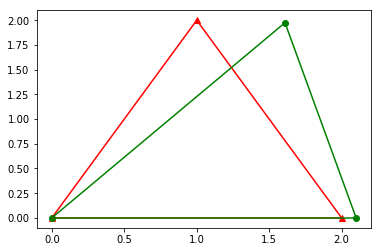

In [35]:
f_dibnodos(x,'r^')
f_dibnodos(x+100*u,'go')
f_dibelems(x,elementos,'r')
f_dibelems(x+100*u,elementos,'g')

In [36]:
plt.show()

Para obtener los esfuerzos en las barras hay que obtener el movimiento axial y multiplicar por la rigidez de la barra. Utilizaremos las funciones f_Ne que devuelve el axil de un elemento dado utilizando como argumentos el elemento, las coordenadas de los nodos y los movimientos de los nodos.
Para obtener los axiles de todos los elementos tenemos la función f_N que aplica f_Ne a todos los elementos.

In [37]:
x+u

array([[ 1.00000000e-20,  1.00000000e-20],
       [ 2.00100000e+00, -1.00000000e-20],
       [ 1.00609017e+00,  1.99975000e+00]])

In [38]:
f_N1 = lambda elemento,coors: fk_1(fk_0(elemento,coors))
f_Ne = lambda elemento,coors,u: (elemento[2]/(fk_1(fk_0(elemento,coors))[3])**2)*(np.dot(f_N1(elemento,coors)[-2:],f_N1(elemento,u)[-2:]))
f_N = lambda elementos,coors,u: list(map(lambda v: f_Ne(v,coors,u),elementos))

Axil del elemento 1

In [39]:
f_Ne(elementos[1],x,u)

1.1180339887498947

Obtención de todos los axiles

In [40]:
f_N(elementos,x,u)

[0.5, 1.1180339887498947, -1.118033988749895]

## Movimientos impuestos
Si tenemos algún movimiento impuesto en el modelo se puede imponer mediante penalización.
Se impone una restricción en el grado de libertad correspondiente y se aplica una fuerza en ese mismo grado de libertad de valor el movimiento impuesto multiplicado por la constante de penalización.
Veamos el ejemplo anterior donde en vez de aplicar una fuerza se desea que el nodo $2$ se mueva $-0.2$ en direción $x$
Añadiríamos una nueva condición de contorno y aplicaríamos la fuerza correspondiente.

In [41]:
cc2 = cc+[[2,0]]
fuerzas2 = [[2,0,-kpen*0.2]]

Resolvemos y obtenemos el resultado previsto.

In [42]:
u2 = f_solve(x,elementos,fuerzas2,cc2)
print(u2)

[[-3.28398061e-19 -3.28398061e-19]
 [-3.28398061e-02  3.28398061e-19]
 [-2.00000000e-01  8.20995152e-03]]


In [43]:
print(u2)

[[-3.28398061e-19 -3.28398061e-19]
 [-3.28398061e-02  3.28398061e-19]
 [-2.00000000e-01  8.20995152e-03]]


que se puede dibujar utlizando los movimientos a escala 1:1

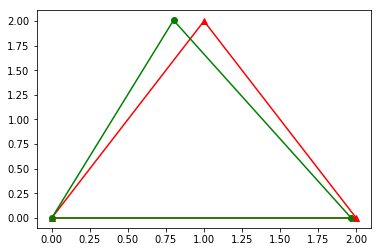

In [44]:
f_dibnodos(x,'r^')
f_dibnodos(x+u2,'go')
f_dibelems(x,elementos,'r')
f_dibelems(x+u2,elementos,'g')

## Generación de nodos
Con el fin facilitar la generación de los datos de los modelos vamos a incluir unas funciones para la generación de coordenadas y nodos.
La función que usaremos es gennodos.
Tiene los siguientes argumentos:

1. xf. Función de las variables (u,v)
2. yf. Función de las variables (u,v)
3. ues. Rango de los valores de u en la forma [u0,uf,nu]
3. ves. Rango de los valores de v en la forma [v0,vf,nv]
3. patterns. Esquema de numeración de los nodos.
3. n0. Número del primer nodo generado.
4. ntot. Número total de nodos del modelo.

y devuelve el array de coordenadas de los nodos.
Las funciones *xf(u,v)->u*   y *yf(u,v)->v* están ya predefinidas.

El único argumento que hay que explicar es *patterns* que establece como se van asignando números de nodos a las coordenadas que se van generando.
Se generan $nu\timesnv$ coordenadas que se obtienen evaluando las funciones xf e yf sobre el producto cartesiano de los nu valores generados entre u0 y uf por los nv valores generados entre v0 y vf.
La forma de asignar los nodos es utilizando la lista patterns [[d1,s1],[d2,s2],...]
Se van asignando nodos a las coordenadas empezando por n0, a cada incremento de s1 de las coordenadas (las $nu\timesnv$ coordenadas) se incrementa d1 el índice del nodo. Se hace lo mismo con cada par de valores [d,s] de la lista patterns.

In [45]:
xf = lambda u,v: u
yf = lambda u,v: v
f1  =lambda u: np.linspace(u[0],u[1],u[2])
f2 = lambda u,v : np.meshgrid(f1(u),f1(v))
f3 = lambda xu,u,v: xu(*f2(u,v)).reshape(u[2]*v[2],1)
f4 = lambda xu,yu,u,v : np.hstack((f3(xu,u,v),f3(yu,u,v)))
faux = lambda patterns,ntot: map(lambda x: [x[0],x[1],ntot],patterns)
fn1 = lambda d1,s1,n : (np.cumsum((np.ones(int(n/s1)))).reshape((int(n/s1),1))*d1-d1 + np.zeros(s1)).reshape(1,n)
fn2 = lambda d1,s1,n: fn1(d1,s1,(int((n-1)/s1)+1)*s1)[0][0:n].reshape(1,n)
fnumer = lambda ues,ves,patterns,n0: np.sum(list(map(lambda u: fn2(*u),faux(patterns,ues[2]*ves[2]))),dtype=int,axis=0)+n0 
nauxf = lambda nnodos: np.hstack((np.ones((1,nnodos),dtype=int)*0,np.ones((1,nnodos),dtype=int))).reshape(nnodos*2)
ensambf = lambda puntos,nodos,ntot: sp.coo_matrix((np.hstack((puntos[:,0],puntos[:,1])), (np.hstack((nodos,nodos)).reshape(nodos.size*2), nauxf(nodos.size))),shape=(ntot,2)).toarray()
gennodos=lambda xf,yf,ues,ves,patterns,n0,ntot:ensambf(f4(xf,yf,ues,ves),fnumer(ues,ves,patterns,n0),ntot)


Si queremos generar 6 nodos separados 1 en el eje $x$ a partir del origen.

In [46]:
xl1 = gennodos(xf,yf,[0,5,6],[0,0,1],[[1,1]],0,6)

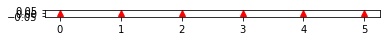

In [47]:
ax = plt.gca()
ax.set_aspect('equal')
f_dibnodos(xl1,'r^')

Si queremos generar una malla de nodos en un rectángulo de lados 4x2 y queremos 6 nodos en el lado sobre el eje $x$ y $3$ sobre el eje $y$ con la numeración empezando por cero y creciendo según el eje $x$

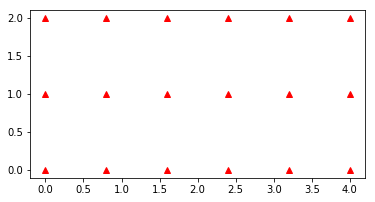

In [48]:
xl2 = gennodos(xf,yf,[0,4,6],[0,2,3],[[1,1]],0,18)
ax = plt.gca()
ax.set_aspect('equal')
f_dibnodos(xl2,'r^')

In [49]:
print(xl2)

[[0.  0. ]
 [0.8 0. ]
 [1.6 0. ]
 [2.4 0. ]
 [3.2 0. ]
 [4.  0. ]
 [0.  1. ]
 [0.8 1. ]
 [1.6 1. ]
 [2.4 1. ]
 [3.2 1. ]
 [4.  1. ]
 [0.  2. ]
 [0.8 2. ]
 [1.6 2. ]
 [2.4 2. ]
 [3.2 2. ]
 [4.  2. ]]


Si queremos una malla de nodos sobre un cuarto de un sector circular entre los radios 3 y 5 con 8 nodos en la dirección del radio y 20 nodos circunferencialmente.

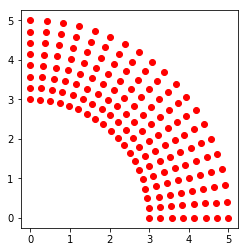

In [50]:
xf3 = lambda u,v: u*np.cos(v)
yf3 = lambda u,v: u*np.sin(v)
xl3 = gennodos(xf3,yf3,[3,5,8],[0,np.pi/2,20],[[1,1]],0,160)
ax = plt.gca()
ax.set_aspect('equal')
f_dibnodos(xl3,'ro')


## Generación de elementos
Para la generación de elementos se seguirá un esquema similar que para la generación de nodos salvo que cada elemento tiene varios nodos sobre los que se aplicará el esquema.
Utilizaremos la función genelem que tiene los siguientes argumentos:
1. *patterns* funciona de forma similar a la generación de nodos [[d11,d12,s1],[d21,d22,s2]...]
2. elbase. Son los nodos del primer elemento.
3. nelem. Número de elementos a generar.
4. x. Coordenadas del modelo.
5. eaf. Una función dependiente de (x,y) que evaluada en el punto medio de cada barra nos devuelve el valor de $EA$, siendo $E$ el módulo de Young y $A$ la sección de la barra.

Por omisión se dispone de la función fc que con un argumento constante genera la función constante.

In [51]:
fc = lambda f: lambda x,y: f
fpat3 = lambda pat,elbase,nelem: list(map(lambda i: [[0,1,nelem],[0,1,1]]+[list(map(lambda x: [x[i],x[-1]],pat))]+[elbase[i]],np.arange(len(elbase))))
# patern ,elemento base, nelementos
#list(map(lambda x: fnumer(*x),res3))
genelem0 = lambda patterns,elbase,nelem: np.hstack(list(map(lambda x: fnumer(*x).reshape(nelem,1),fpat3(patterns,elbase,nelem)))).tolist()
genelem1 = lambda elementos,x,eaf:list(map(lambda u: [u[0],u[1],eaf(0.5*(x[u[0]][0]+x[u[1]][0]),0.5*(x[u[0]][1]+x[u[1]][1]))],elementos))
# genelem3 genera la lista de elementos con la funcion eaf(x,y) aplicada al punto medio
genelem = lambda patterns,elbase,nelem,x,eaf:genelem1(genelem0(patterns,elbase,nelem),x,eaf)


## Generacion de fuerzas nodales con una funcion de (x,y) evaluada en el nodo
Se generan de forma similar a los elementos.

In [52]:
genfuerzas0 = lambda patterns,elbase,nelem: np.hstack(list(map(lambda x: fnumer(*x).reshape(nelem,1),fpat3(patterns,elbase,nelem)))).tolist()
genfuerzas1 = lambda elementos,x,ffuer:list(map(lambda u: [u[0],u[1],ffuer(x[u[0]][0],x[u[0]][1])],elementos))
# genelem3 genera la lista de elementos con la funcion eaf(x,y) aplicada al punto medio
genfuerzas = lambda patterns,elbase,nelem,x,eaf:genfuerzas1(genfuerzas0(patterns,elbase,nelem),x,eaf)

### Ejemplos de generación de elementos.

Generación de elementos en una dimensión correspondiente a los nodos xl1 generados anteriormente.

In [53]:
genelem([[1,1,1]],[0,1],4,xl1,fc(1000))

[[0, 1, 1000], [1, 2, 1000], [2, 3, 1000], [3, 4, 1000]]

### Solución del problema de abaqus 1d

In [54]:
x = gennodos(xf,yf,[0,10,11],[0,0,1],[[1,1]],0,11)

In [55]:
elems = genelem([[1,1,1]],[0,1],10,x,fc(1000))

Las condiciones de contorno se pueden generar con una de las funciones de generar elementos

In [56]:
cc1 = genelem0([[1,0,1]],[0,1],11)

In [57]:
cc1

[[0, 1],
 [1, 1],
 [2, 1],
 [3, 1],
 [4, 1],
 [5, 1],
 [6, 1],
 [7, 1],
 [8, 1],
 [9, 1],
 [10, 1]]

Y se añade la condición de contorno que falta de movimiento coaccionado en x en el nodo 0.

In [58]:
cc = cc1 + [[0,0]]

Para la inclusión de la carga volumétrica me ayudo de unas funciones auxiliares para poder generar las cargas nodales quivalentes.

In [59]:
fq = lambda x,y: 0.2+0.04*x
fq1 = lambda x,y: 1/6*(2*fq(x,0)+fq(x+1,0))
fq2 = lambda x,y: 1/6*(fq(x-1,0)+2*fq(x,0))

In [60]:
fuerz1 = genfuerzas([[1,0,1]],[0,0],10,x,fq1)
fuerz2 = genfuerzas([[1,0,1]],[1,0],10,x,fq2)

Añado la fuerza nodal del extremo libre.

In [61]:
fuerzas = fuerz1+fuerz2+[[10,0,5]]

In [62]:
fuerzas

[[0, 0, 0.10666666666666666],
 [1, 0, 0.12666666666666665],
 [2, 0, 0.14666666666666667],
 [3, 0, 0.16666666666666666],
 [4, 0, 0.18666666666666668],
 [5, 0, 0.20666666666666667],
 [6, 0, 0.22666666666666668],
 [7, 0, 0.24666666666666665],
 [8, 0, 0.26666666666666666],
 [9, 0, 0.2866666666666667],
 [1, 0, 0.11333333333333334],
 [2, 0, 0.13333333333333333],
 [3, 0, 0.15333333333333332],
 [4, 0, 0.17333333333333334],
 [5, 0, 0.19333333333333336],
 [6, 0, 0.21333333333333332],
 [7, 0, 0.23333333333333334],
 [8, 0, 0.2533333333333333],
 [9, 0, 0.2733333333333333],
 [10, 0, 0.29333333333333333],
 [10, 0, 5]]

In [63]:
u = f_solve(x,elems,fuerzas,cc)
print(u)

[[9.00000000e-20 0.00000000e+00]
 [8.89333333e-03 0.00000000e+00]
 [1.75466667e-02 0.00000000e+00]
 [2.59200000e-02 0.00000000e+00]
 [3.39733333e-02 0.00000000e+00]
 [4.16666667e-02 0.00000000e+00]
 [4.89600000e-02 0.00000000e+00]
 [5.58133333e-02 0.00000000e+00]
 [6.21866667e-02 0.00000000e+00]
 [6.80400000e-02 0.00000000e+00]
 [7.33333333e-02 0.00000000e+00]]


Leemos los resultados de abaqus

In [64]:
import pandas as pd
data = pd.read_csv('u3.txt', header = None)
u3_abaqus = data.to_numpy()

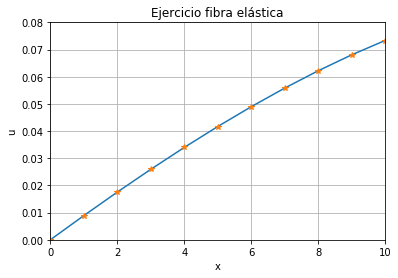

In [65]:
plt.xlabel('x')
plt.ylabel('u')
plt.title('Ejercicio fibra elástica')
plt.axis([0, 10, 0, 0.08])
plt.grid(True)
plt.plot(x[:,0],u[:,0],x[:,0],u3_abaqus[:,1],'*')

In [66]:
axiles = f_N(elems,x,u)

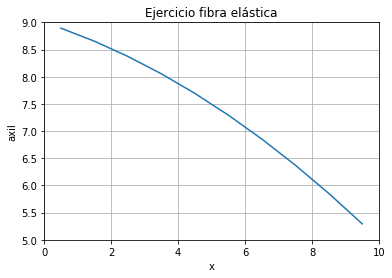

In [67]:
plt.xlabel('x')
plt.ylabel('axil')
plt.title('Ejercicio fibra elástica')
plt.axis([0, 10, 5, 9])
plt.grid(True)
plt.plot(np.linspace(0.5,9.5,10),axiles[:])

In [68]:
import pandas as pd
data = pd.read_csv('s33.rpt', header = None)
s33_abaqus = data.to_numpy()

In [69]:
s33_abaqus[:,2]

array([5.29, 5.85, 6.37, 6.85, 7.29, 7.69, 8.05, 8.37, 8.65, 8.89])

In [70]:
s33_ab = np.flip(s33_abaqus[:,2])

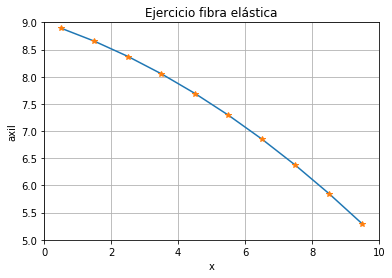

In [71]:
plt.xlabel('x')
plt.ylabel('axil')
plt.title('Ejercicio fibra elástica')
plt.axis([0, 10, 5, 9])
plt.grid(True)
plt.plot(np.linspace(0.5,9.5,10),axiles[:],np.linspace(0.5,9.5,10),s33_ab,'*')

In [210]:
nx = 15
x = gennodos(xf,yf,[0,nx*8,nx+1],[0,2,2],[[1,1]],0,2*nx+2)

In [211]:
els1 = genelem([[1,1,1],[1,1,nx]],[0,1],2*nx,x,fc(1e6))

In [212]:
els2 = genelem([[1,1,1]],[0,nx+1],nx+1,x,fc(1e6))

In [213]:
els3 = genelem([[1,1,1]],[0,nx+2],nx,x,fc(1e6))
els4 = genelem([[1,1,1]],[1,nx+1],nx,x,fc(1e6))

In [214]:
elementos = els1+els2+els3+els4

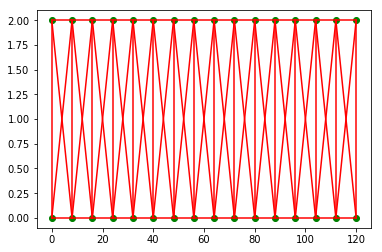

In [216]:
#ax = plt.gca()
#ax.set_aspect('equal')
f_dibnodos(x);
f_dibelems(x,elementos);

In [217]:
cc = [[0,0],[0,1],[nx,1]]
fuerzas = genfuerzas([[1,0,1]],[nx+1,1],nx+1,x,fc(10))

In [218]:
u=f_solve(x,elementos,fuerzas,cc)

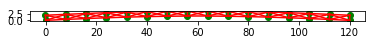

In [219]:
ax = plt.gca()
ax.set_aspect('equal')
f_dibnodos(x+u);
f_dibelems(x+u,elementos);

Podemos generar el modelo con forma de arco parabólico. Basta con utilizar las ecuaciones de la parábola.
En este caso para una luz de 120 metros y una flecha de 30 metros.
Se ha considerado que el canto de la viga se genera según la normal a la parábola.

In [267]:
xf2 = lambda u,v: u+v*(2/120*u)/np.sqrt(1+4*(1/120)*(1/120)*u*u)
yf2 = lambda u,v: -1/120*u*u+v*1/np.sqrt(1+(4/120)*(1/120)*u*u)
x = gennodos(xf2,yf2,[-nx*4,nx*4,nx+1],[0,4,2],[[1,1]],0,2*nx+2)

Dibujamos los nodos solamente.

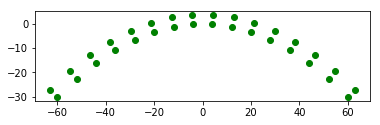

In [268]:
ax = plt.gca()
ax.set_aspect('equal')
f_dibnodos(x);

Los elementos son exactamente los mismos que en el caso anterior.

In [269]:
els1 = genelem([[1,1,1],[1,1,nx]],[0,1],2*nx,x,fc(1e6))

In [270]:
els2 = genelem([[1,1,1]],[0,nx+1],nx+1,x,fc(1e6))

In [271]:
els3 = genelem([[1,1,1]],[0,nx+2],nx,x,fc(1e6))
els4 = genelem([[1,1,1]],[1,nx+1],nx,x,fc(1e6))

In [272]:
elementos = els1+els2+els3+els4

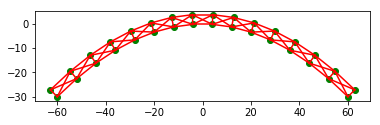

In [273]:
ax = plt.gca()
ax.set_aspect('equal')
f_dibnodos(x);
f_dibelems(x,elementos);

In [274]:
cc = [[0,0],[0,1],[nx,1]]
fuerzas = genfuerzas([[1,0,1]],[nx+1,1],nx+1,x,fc(-10))

In [275]:
u=f_solve(x,elementos,fuerzas,cc)

In [ ]:
Dibujamos los nodos sin deformar y los elementos según la deformada.

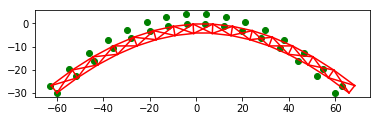

In [278]:
ax = plt.gca()
ax.set_aspect('equal')
f_dibnodos(x);
f_dibelems(x+u*10,elementos);

Podemos obtener las reacciones que serán las fuerzas asociadas a las restricciones. En este caso, por ejemplo,las reacciones verticales están asociadas a los nodos u[0] y u[nx].  Como el apoyo derecho es un carrito y no hay fuerzas horizontales las únicas reacciones son las verticales que se pueden obtener multiplicando los movimientos de los nodos coaccionados por la constante de penalización $kpen$  
Las fuerzas aplicadas son unas fuerzas concentradas en los nodos superiores de valor $-10$ que hacen un total de $-160$.

In [286]:
u[0]

array([ 5.85482703e-32, -8.00000000e-19])

In [287]:
u[nx]

array([ 5.93152636e-01, -8.00000000e-19])

In [290]:
u[0][1]*kpen

-79.99999999996999

In [291]:
u[nx][1]*kpen

-79.99999999996753